<h1 align="center">Introduction to Machine Learning - 25737-2</h1>
<h4 align="center">Dr. R. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>


**<font color='red'>Plagiarism is strongly prohibited!</font>**


**Student Name**: Tina Halimi

**Student ID**: 400101078





## Importing Libraries

First we import libraries that we need for this assignment.

In [1]:
# import any other libraries needed below

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## Reading Data and Preprocessing

In this section, we want to read data from a CSV file and then preprocess it to make it ready for the rest of the problem.

First, we read the data in the cell below and extract an $m \times n$ matrix, $X$, and an $m \times 1$ vector, $Y$, from it, which represent our knowledge about the features of the data (`X1`, `X2`, `X3`) and the class (`Y`), respectively. Note that by $m$, we mean the number of data points and by $n$, we mean the number of features.

In [2]:
### START CODE HERE ###
data = pd.read_csv('data2_logistic.csv')

X = data[['X1', 'X2', 'X3']] 
Y = data['Y']

X = X.values
Y = Y.values

### END CODE HERE ###

print(X.shape)
print(Y.shape)

(10000, 3)
(10000,)


Next, we should normalize our data. For normalizing a vector $\mathbf{x}$, a very common method is to use this formula:

$$
\mathbf{x}_{norm} = \dfrac{\mathbf{x} - \overline{\mathbf{x}}}{\sigma_\mathbf{x}}
$$

Here, $\overline{x}$ and $\sigma_\mathbf{x}$ denote the mean and standard deviation of vector $\mathbf{x}$, respectively. Use this formula and store the new $X$ and $Y$ vectors in the cell below.

**Question**: Briefly explain why we need to normalize our data before starting the training.

**Answer**:

### Reasons for Data Normalization in Machine Learning

1. **Improved convergence**: Normalizing the features helps algorithms converge faster during training. When features are on different scales, some might dominate the optimization process, leading to slower convergence or getting stuck in local minima.

2. **Better performance**: Normalization can lead to better performance of the model, especially for algorithms that are sensitive to the scale of features, such as gradient-based optimization algorithms (e.g., gradient descent) and distance-based algorithms (e.g., K-nearest neighbors).

3. **Regularization**: Normalization can act as a form of regularization, preventing large weights from dominating the learning process. This can help prevent overfitting and improve the generalization ability of the model.

4. **Interpretability**: Normalizing the data can also improve the interpretability of the model by making the coefficients or weights associated with each feature more comparable and easier to interpret.

Overall, normalizing the data before training helps ensure that the learning algorithm operates effectively and efficiently, leading to better model performance and interpretability.


In [3]:
### START CODE HERE ###

X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)

X_norm = (X - X_mean) / X_std

# Y_mean = np.mean(Y)
# Y_std = np.std(Y)
# Y_norm = (Y - Y_mean) / Y_std

### END CODE HERE ###

Finally, we should add a column of $1$s at the beginning of $X$ to represent the bias term. Do this in the next cell. Note that after this process, $X$ should be an $m \times (n+1)$ matrix.

In [4]:
### START CODE HERE ###

X_with_bias = np.concatenate((np.ones((X_norm.shape[0], 1)), X_norm), axis=1)
print("Shape of X_with_bias:", X_with_bias.shape)

### END CODE HERE ###

# print(X.shape)

Shape of X_with_bias: (10000, 4)


## Training Model

### Sigmoid Function
You should begin by implementing the $\sigma(\mathbf{x})$ function. Recall that the logistic regression hypothesis $\mathcal{h}()$ is defined as:
$$
\mathcal{h}_{\theta}(\mathbf{x}) = \mathcal{g}(\theta^\mathbf{T}\mathbf{x})
$$
where $\mathcal{g}()$ is the sigmoid function as:
$$
\mathcal{g}(\mathbf{z}) = \frac{1}{1+exp^{-\mathbf{z}}}
$$
The Sigmoid function has the property that $\mathbf{g}(+\infty)\approx 1$ and $\mathcal{g}(−\infty)\approx0$. Test your function by calling `sigmoid(z)` on different test samples. Be certain that your sigmoid function works with both vectors and matrices - for either a vector or a matrix, your function should perform the sigmoid function on every element.

In [5]:
def sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    return s

test_scalar = 0
test_vector = np.array([-10, 0, 10])
test_matrix = np.array([[-1, 0, 1], [-2, -1, 0]])

print("Sigmoid of scalar:", sigmoid(test_scalar))
print("Sigmoid of vector:", sigmoid(test_vector))
print("Sigmoid of matrix:")
print(sigmoid(test_matrix))


Sigmoid of scalar: 0.5
Sigmoid of vector: [4.53978687e-05 5.00000000e-01 9.99954602e-01]
Sigmoid of matrix:
[[0.26894142 0.5        0.73105858]
 [0.11920292 0.26894142 0.5       ]]


### Cost Function 
Implement the functions to compute the cost function. Recall the cost function for logistic regression is a scalar value given by:
$$
\mathcal{J}(\theta) = \sum_{i=1}^{n}[-y^{(i)}\log{(\mathcal{h}_\theta(\mathbf{x}^{(i)}))}-(1-y^{(i)})\log{(1-\mathcal{h}_\theta(\mathbf{x}^{(i)}))}] + \frac{\lambda}{2}||\theta||_2^2
$$

In [6]:
def computeCost(theta, X, y, regLambda):
    '''
    Computes the objective function
    Arguments:
        theta is d-dimensional numpy vector
        X is a n-by-d numpy matrix
        y is an n-dimensional numpy vector
        regLambda is the scalar regularization constant
    Returns:
        a scalar value of the cost  ** make certain you're not returning a 1 x 1 matrix! **
    '''
    m, n = X.shape
    h = sigmoid(X.dot(theta))
    loss = -np.sum(y * np.log(h) + (1 - y) * np.log(1 - h)) / m
    regularization_term = regLambda / (2 * m) * np.sum(theta[1:] ** 2)
    loss += regularization_term
    return loss


### Gradient of the Cost Function
Now, we want to calculate the gradient of the cost function. The gradient of the cost function is a d-dimensional vector.\
We must be careful not to regularize the $\theta_0$ parameter (corresponding to the first feature we add to each instance), and so the 0's element is given by:
$$
\frac{\partial \mathcal{J}(\theta)}{\partial \theta_0} = \sum_{i=1}^n (\mathcal{h}_\theta(\mathbf{x}^{(i)})-y^{(i)})
$$

Question: What is the answer to this problem for the $j^{th}$ element (for $j=1...d$)?

Answer:

The gradient of the cost function with respect to the $j^{th}$ element (for $j = 1...d$) is given by:

$$
\frac{\partial \mathcal{J}(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m} (\mathcal{h}_\theta(\mathbf{x}^{(i)}) - y^{(i)}) \cdot x_j^{(i)} + \frac{\lambda}{m} \cdot \theta_j \quad \text{for } j > 0
$$

$$
\frac{\partial \mathcal{J}(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^{m} (\mathcal{h}_\theta(\mathbf{x}^{(i)}) - y^{(i)})
$$

This expression represents the gradient of the cost function with respect to each parameter $\theta_j$, where $j = 1...d$. For $j > 0$, we add the regularization term $\frac{\lambda}{m} \cdot \theta_j$, while for $j = 0$, there is no regularization applied.


In [7]:
def computeGradient(theta, X, y, regLambda):
    '''
    Computes the gradient of the objective function
    Arguments:
        theta is d-dimensional numpy vector
        X is a n-by-d numpy matrix
        y is an n-dimensional numpy vector
        regLambda is the scalar regularization constant
    Returns:
        the gradient, an d-dimensional vector
    '''
    m, n = X.shape
    h = sigmoid(X.dot(theta))
    
    grad = np.dot(X.T, (h - y) / m)
    regularization_term = regLambda / m * theta
    regularization_term[0] = 0 
    grad += regularization_term
    return grad

### Training and Prediction
Once you have the cost and gradient functions complete, implemen tthe fit and predict methods.\
Your fit method should train the model via gradient descent, relying on the cost and gradient functions. This function should return two parameters. The first parameter is $\theta$, and the second parameter is a `numpy` array that contains the loss in each iteration. This array is indicated by `loss_history` in the code.\
Instead of simply running gradient descent for a specific number of iterations, we will use a more sophisticated method: we will stop it after the solution hasconverged. Stop the gradient descent procedure when $\theta$ stops changing between consecutive iterations. You can detect this convergence when:
$$
||\theta_{new}-\theta_{old}||_2 <= \epsilon,
$$
for some small $\epsilon$ (e.g, $\epsilon=10E-4$).\
For readability, we’d recommend implementing this convergence test as a dedicated function `hasConverged`.

In [8]:
def fit(X, y, regLambda=0.01, alpha=0.01, epsilon=1e-4, maxNumIters=100):
    '''
    Trains the model
    Arguments:
        X           is a n-by-d numpy matrix
        y           is an n-dimensional numpy vector
        maxNumIters is the maximum number of gradient descent iterations
        regLambda   is the scalar regularization constant
        epsilon     is the convergence rate
        alpha       is the gradient descent learning rate
    '''
    m, n = X.shape
    theta = np.zeros(n)
    loss_history = []

    for i in range(maxNumIters):
        grad = computeGradient(theta, X, y, regLambda)
        theta_prev = np.copy(theta)
        theta -= alpha * grad

        loss = computeCost(theta, X, y, regLambda)
        loss_history.append(loss)

        if hasConverged(theta_prev, theta, epsilon):
            break
        
        theta_prev = np.copy(theta)
    return theta, loss_history

def hasConverged(theta_old, theta_new, epsilon):
    '''
    Return if the theta converged or not
    Arguments:
        theta_old   is the theta calculated in previous iteration
        theta_new   is the theta calculated in current iteration
        epsilon     is the convergence rate
    '''
    return np.linalg.norm(theta_new - theta_old) <= epsilon

Finally, we want to evaluate our loss for this problem. Complete the cell below to calculate and print the loss of each iteration and the final theta of your model.

In [9]:
### START CODE HERE ###

theta, loss_history = fit(X_with_bias, Y) # calculating theta and loss of each iteration

print("\nFinal Theta:", theta)

for i, loss in enumerate(loss_history):
    print("Iteration {}: Loss = {}".format(i+1, loss))


### END CODE HERE ###


Final Theta: [-0.07917594 -0.12794085  0.34107905  0.00717197]
Iteration 1: Loss = 0.6913809060118176
Iteration 2: Loss = 0.6896234948289701
Iteration 3: Loss = 0.6878749023208994
Iteration 4: Loss = 0.6861350838563361
Iteration 5: Loss = 0.6844039948667454
Iteration 6: Loss = 0.682681590849767
Iteration 7: Loss = 0.6809678273725951
Iteration 8: Loss = 0.6792626600752987
Iteration 9: Loss = 0.677566044674081
Iteration 10: Loss = 0.6758779369644806
Iteration 11: Loss = 0.6741982928245116
Iteration 12: Loss = 0.6725270682177437
Iteration 13: Loss = 0.6708642191963253
Iteration 14: Loss = 0.6692097019039447
Iteration 15: Loss = 0.6675634725787335
Iteration 16: Loss = 0.6659254875561126
Iteration 17: Loss = 0.6642957032715767
Iteration 18: Loss = 0.6626740762634232
Iteration 19: Loss = 0.6610605631754218
Iteration 20: Loss = 0.6594551207594275
Iteration 21: Loss = 0.6578577058779349
Iteration 22: Loss = 0.6562682755065772
Iteration 23: Loss = 0.6546867867365672
Iteration 24: Loss = 0.6531

### Testing Your Implementation
To test your logistic regression implementation, first you should use `train_test_split` function to split dataset into three parts:

- 70% for the training set
- 20% for the validation set
- 10% for the test set

Do this in the cell below.

In [10]:
### START CODE HERE ###

X_train, X_temp, Y_train, Y_temp = train_test_split(X_with_bias, Y, test_size=0.3, random_state=42)
X_test, X_val, Y_test, Y_val = train_test_split(X_temp, Y_temp, test_size=2/3, random_state=42)

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_val shape:", X_val.shape)
print("Y_val shape:", Y_val.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

### END CODE HERE ###

X_train shape: (7000, 4)
Y_train shape: (7000,)
X_val shape: (2000, 4)
Y_val shape: (2000,)
X_test shape: (1000, 4)
Y_test shape: (1000,)


Then, you should complete `predict` function to find the weight vector and the loss on the test data.

In [11]:
def predict(X, theta):
    '''
    Use the model to predict values for each instance in X
    Arguments:
        theta is d-dimensional numpy vector
        X     is a n-by-d numpy matrix
    Returns:
        an n-dimensional numpy vector of the predictions, the output should be binary (use h_theta > .5)
    '''
    h = sigmoid(X.dot(theta))
    Y = (h > 0.5).astype(int)
    return Y


Now, run the `fit` and `predict` function for different values of the learning rate and regularization constant. Plot the `loss_history` of these different values for train and test data both in the same figure.

**Question**: Discuss the effect of the learning rate and regularization constant and find the best values of these parameters.

**Answer**:

### Effect of Learning Rate and Regularization Constant

#### Learning Rate (Alpha)
- **Definition**: The learning rate controls the step size of gradient descent updates.
- **Effect**:
  - **High Learning Rate**: May cause the algorithm to diverge, overshooting the minimum of the cost function.
  - **Low Learning Rate**: Can lead to slow convergence, especially on large datasets.
- **Optimization**:
  - Try a range of values (e.g., 0.01, 0.05, 0.1) and choose the one resulting in fast convergence without oscillations or divergence.

#### Regularization Constant (Lambda)
- **Definition**: Controls the importance of regularization in the cost function.
- **Effect**:
  - **Higher Constant**: Imposes stronger penalty on large weights, leading to simpler models.
  - **Lower Constant**: Allows model to fit training data more closely but increases risk of overfitting.
- **Optimization**:
  - Determine problem-dependent optimal value using techniques like cross-validation.
  - Common values to try: 0 (no regularization), 0.1, 1, 10.

#### Finding the Best Values
- **Grid Search or Random Search**:
  - Search over a range of values for both learning rate and regularization constant.
- **Evaluation**:
  - Evaluate model's performance using a validation set or cross-validation.
- **Selection**:
  - Choose parameters yielding lowest validation loss.
- **Visualization**:
  - Plot performance using graphs to observe loss changes with different hyperparameters.

In practice, experimentation with different combinations of learning rates and regularization constants, along with visualization and evaluation, helps in finding the best values for optimal model performance.


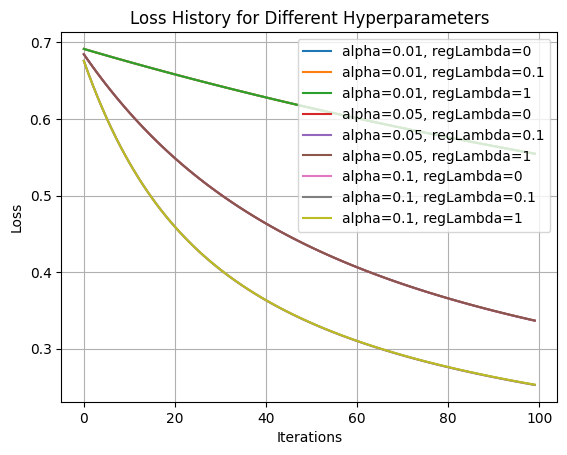

In [12]:
### START CODE HERE ###

learning_rates = [0.01, 0.05, 0.1]
reg_constants = [0, 0.1, 1]

train_loss_history = []
# val_loss_history = []
test_loss_history = []

for alpha in learning_rates:
    for regLambda in reg_constants:
        
        theta, loss_history = fit(X_train, Y_train, regLambda=regLambda, alpha=alpha)
        
        train_predictions = predict(X_train, theta)
        # val_predictions = predict(X_val, theta)
        test_predictions = predict(X_test, theta)
        
        train_loss = computeCost(theta, X_train, Y_train, regLambda)
        val_loss = computeCost(theta, X_val, Y_val, regLambda)
        test_loss = computeCost(theta, X_test, Y_test, regLambda)
        
        train_loss_history.append(train_loss)
        # val_loss_history.append(val_loss)
        test_loss_history.append(test_loss)
        
        plt.plot(loss_history, label=f"alpha={alpha}, regLambda={regLambda}")

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss History for Different Hyperparameters')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()
  
### END CODE HERE ###

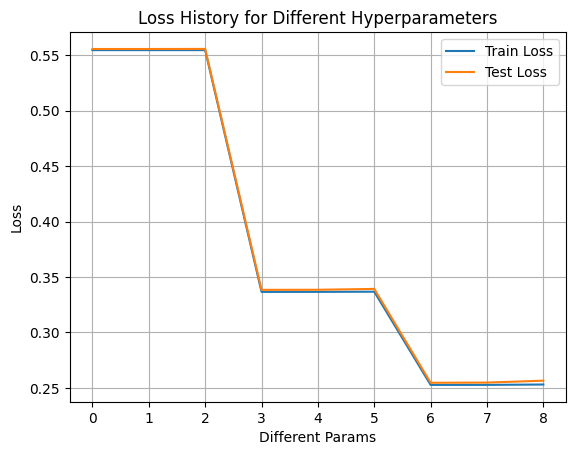

In [13]:
plt.plot(train_loss_history, label='Train Loss')
# plt.plot(val_loss_history, label='Validation Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.xlabel('Different Params')
plt.ylabel('Loss')
plt.title('Loss History for Different Hyperparameters')
plt.legend()
plt.grid(True)
plt.show()

## Naive Bayes

In this part, you will use the `GaussianNB` classifier to classify the data. You should not change the default parameters of this classifier. First, train the classifier on the training set and then find the accuracy of it on the test set.

**Question**: What is the accuracy of this method on test set?

**Answer**:

In [14]:
### START CODE HERE ###

nb_classifier = GaussianNB()
nb_classifier.fit(X_train, Y_train)
Y_pred = nb_classifier.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy of Gaussian Naive Bayes classifier on test set: {:.2f}%".format(accuracy * 100))

### END CODE HERE ###

Accuracy of Gaussian Naive Bayes classifier on test set: 92.90%


## LDA (Linear Discriminant Analysis)

In this part, you will use the `LinearDiscriminantAnalysis` classifier to classify the data. You should not change the default parameters of this classifier. First, train the classifier on the training set and then find the accuracy of it on the test set.

**Question**: What is the accuracy of this method on test set?

**Answer**:

In [15]:
### START CODE HERE ###

lda_classifier = LinearDiscriminantAnalysis()
lda_classifier.fit(X_train, Y_train)
Y_pred = lda_classifier.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy of Linear Discriminant Analysis classifier on test set: {:.2f}%".format(accuracy * 100))

### END CODE HERE ###

Accuracy of Linear Discriminant Analysis classifier on test set: 96.70%


## Conclution

**Question**: What is the best method for classifying this dataset? What is the best accuracy on the test set?

**Answer**:

Based on the provided accuracies:

- **Gaussian Naive Bayes classifier**: 92.90%
- **Linear Discriminant Analysis classifier**: 96.70%

It appears that the Linear Discriminant Analysis (LDA) classifier outperforms the Gaussian Naive Bayes classifier on this dataset, achieving a higher accuracy of 96.70% compared to 92.90%.

Therefore, the **best method** for classifying this dataset is the **Linear Discriminant Analysis (LDA) classifier**.

The **best accuracy** achieved on the test set is **96.70%**, obtained by the Linear Discriminant Analysis classifier.
